In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()  # AD5F235DF639B041
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [3]:
!pip install -q keras
!pip install --upgrade gensim
!pip install regex
!pip install tqdm

    100% |████████████████████████████████| 22.6MB 1.7MB/s 
Requirement not upgraded as not directly required: scipy>=0.18.1 in /usr/local/lib/python3.6/dist-packages (from gensim) (0.19.1)
Requirement not upgraded as not directly required: six>=1.5.0 in /usr/local/lib/python3.6/dist-packages (from gensim) (1.11.0)
Requirement not upgraded as not directly required: numpy>=1.11.3 in /usr/local/lib/python3.6/dist-packages (from gensim) (1.14.3)
    100% |████████████████████████████████| 1.4MB 8.6MB/s 
Requirement not upgraded as not directly required: requests in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim) (2.18.4)
    100% |████████████████████████████████| 133kB 23.9MB/s 
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /usr/local/lib/python3.6/dist-packages (from requests->smart-open>=1.2.1->gensim) (3.0.4)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /usr/local/lib/python3.6/dist-packages (from requests->

    100% |████████████████████████████████| 624kB 4.5MB/s 
  Running setup.py bdist_wheel for regex ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/6b/c9/cf/230425cdd343d6b98e8da5a5841c3dab1e0c8aaa134e29edb0
Successfully built regex
    100% |████████████████████████████████| 51kB 2.0MB/s 


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [5]:
%cd /content/drive/NLP/Project
!ls /content/drive/NLP/Project

/content/drive/NLP/Project
Arabic_Topic_Classification.ipynb  www_sg_100
data.csv			   www_sg_100.trainables.syn1neg.npy
data.rar			   www_sg_100.wv.vectors.npy
drive				   www_sg_100.zip
sentiment_weights.hdf5


In [0]:

import pandas as pd
from sklearn.utils import shuffle
import re as r
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm
from sklearn.model_selection import train_test_split


class Data_PreProcessing:
    
  def __init__(self):
    # replace urls
    self.re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                        .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                        re.MULTILINE|re.UNICODE)
    # replace ips
    self.re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

    # setup tokenizer
    self.tokenizer = WordPunctTokenizer()

    self.vocab = Counter()
  
  
  def text_to_wordlist(self, text, lower=False):
    # replace URLs
    text = self.re_url.sub("URL", text)
    
    # replace IPs
    text = self.re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = self.tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    self.vocab.update(text)
    
    return text
  
  
  def process_sentences(self, list_sentences, lower=False):
    sentences = []
    for text in tqdm(list_sentences):
        txt = self.text_to_wordlist(text, lower=lower)
        sentences.append(txt)
    return sentences
  
  def downloadTwitterData(self):
    !apt install unzip
    !apt install rename
    %cd /content/drive/sentiment
    !wget http://thinknook.com/wp-content/uploads/2012/09/Sentiment-Analysis-Dataset.zip
    !unzip Sentiment-Analysis-Dataset.zip
    !find -name "* *" -type f | rename 's/ /_/g'
  
  
  
  def dataPreprocing(self, csvDataPath, keepCols):  #keepCols = [textColumnName, labelColumnName]

    # Keep only Text Column & Label Column
    data = pd.read_csv(csvDataPath, error_bad_lines=False)
    _df = pd.DataFrame(data)
    cols = [col for col in _df.columns if col not in keepCols]
    df = _df.drop(axis=1, columns=cols)

    # Remove Non Alphapetical Text
    df[keepCols[0]] = df[keepCols[0]].apply((lambda x: r.sub('[^a-zA-z\s]','',x)))

    # Drop Null Samples
    df.dropna(axis=0, inplace=True)

    # Suffle Data Randomly
    df = shuffle(df)

    return df
  
  def loadData(self, df, test_size=0.05):
    Y = pd.get_dummies(df['Sentiment']).values
    X_train, X_test, Y_train, Y_test = train_test_split(df['SentimentText'],Y, test_size = test_size, random_state = 42)
    return X_train, X_test, Y_train, Y_test


In [0]:
def preprocess_prediction(X, dpp):
  from keras.preprocessing.sequence import pad_sequences

  MAX_NB_WORDS = len(dpp.vocab)
  MAX_SEQUENCE_LENGTH = 500
#   WV_DIM = 32

  word_index = {t[0]: i+1 for i,t in enumerate(dpp.vocab.most_common(MAX_NB_WORDS))}
  sequences = [[word_index.get(t, 0) for t in sentence]
           for sentence in X]

  # pad
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                       padding="pre", truncating="post")
  
  return data,word_index
  

In [8]:
from __future__ import print_function, division

from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np


class Sentiment():

  
  def __init__(self , model):
    
    import os
    
    self.model = model
    if os.path.isfile('/content/drive/NLP/Project/sentiment_weights.hdf5'):
      self.load_model(model_name='sentiment')
      print("model loaded")
    else:
      pass

  
  def train(self, X_train, Y_train, epochs=5, batch_size=128, validation_split=0.08):
    
    print(self.model.summary())
    self.save_model()
    return self.model.fit([X_train], Y_train, validation_split=validation_split,
                 epochs=epochs, batch_size=batch_size, shuffle=True,callbacks=self.callbacks_list)
  
  def load_model(self,model_name='sentiment'):
    
    filepath="/content/drive/NLP/Project/%s_weights.hdf5" % model_name
    self.model.load_weights(filepath)
        
      
  def save_model(self,model_name='sentiment'):
      
    filepath="/content/drive/NLP/Project/%s_weights.hdf5" % model_name
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    self.callbacks_list = [checkpoint]
  
  def evaluate(self,X,Y):
    
    scores = self.model.evaluate(X, Y)
    print("%s: %.2f%%" % (self.model.metrics_names[1], scores[1]*100))
    
  def predict(self,X):
    data = pd.DataFrame(X)
    prediction = self.model.predict(data)
    return prediction
      

Using TensorFlow backend.


#Arabic Topic Classification

In [18]:
#!apt-get install unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 2 not upgraded.
Need to get 129 kB of archives.
After this operation, 322 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 unrar amd64 1:5.5.8-1 [129 kB]
Fetched 129 kB in 0s (1,669 kB/s)
Selecting previously unselected package unrar.
(Reading database ... 19735 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a5.5.8-1_amd64.deb ...
Unpacking unrar (1:5.5.8-1) ...
Setting up unrar (1:5.5.8-1) ...
update-alternatives: using /usr/bin/unrar-nonfree to provide /usr/bin/unrar (unrar) in auto mode


In [19]:
#!wget https://sourceforge.net/projects/ar-text-mining/files/Arabic-Corpora/osac-uft8.7z 
#!unrar x data.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from data.rar

Extracting  data.csv                                                      14% 29% 44% 58% 73% 88% 99%  OK 
All OK


In [49]:
#!wget https://archive.org/download/aravec2.0/www_sg_100.zip

--2018-05-11 21:10:16--  https://archive.org/download/aravec2.0/www_sg_100.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801509.us.archive.org/29/items/aravec2.0/www_sg_100.zip [following]
--2018-05-11 21:10:17--  https://ia801509.us.archive.org/29/items/aravec2.0/www_sg_100.zip
Resolving ia801509.us.archive.org (ia801509.us.archive.org)... 207.241.228.159
Connecting to ia801509.us.archive.org (ia801509.us.archive.org)|207.241.228.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180255916 (172M) [application/zip]
Saving to: ‘www_sg_100.zip’

www_sg_100.zip        3%[                    ]   5.80M   243KB/s    eta 11m 50s

www_sg_100.zip      100%[===================>] 171.91M   246KB/s    in 12m 19s 



2018-05-11 21:22:41 (238 KB/s) - ‘www_sg_100.zip’ saved [180255916/180255916]



In [50]:
#!unzip www_sg_100.zip

Archive:  www_sg_100.zip
  inflating: www_sg_100              
  inflating: www_sg_100.trainables.syn1neg.npy  
  inflating: www_sg_100.wv.vectors.npy  


In [0]:
def W2V_Arabic(sentences,MAX_SEQUENCE_LENGTH,WV_DIM,MAX_NB_WORDS,word_index):
    
    from gensim.models import Word2Vec
    import numpy as np
    import gensim

    model = gensim.models.Word2Vec.load('/content/drive/NLP/Project/www_sg_100')
    word_vectors = model.wv
    #print("Number of word vectors: {}".format(len(word_vectors.vocab)))

    nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
    # we initialize the matrix with random numbers
    wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
    for word, i in word_index.items():
        if i >= MAX_NB_WORDS:
            continue
        try:
            embedding_vector = word_vectors[word]
            # words not found in embedding index will be all-zeros.
            wv_matrix[i] = embedding_vector
        except:
            pass
    
    return wv_matrix ,nb_words

In [10]:
arDf = pd.read_csv('data.csv', encoding='utf-8', error_bad_lines=False)
arDf.head()

sentence     tag
0   ‭BBC Arabic‬ - ‮اقتصاد وأعمال‬ - ‮تطوير حقول ...  اقتصاد
1   بغداد الى السيولة النقدية من ارتفاع مبيعات ال...  اقتصاد
2   ‭BBC Arabic‬ - ‮اقتصاد وأعمال‬ - ‮الجزائر: سا...  اقتصاد
3   ‭BBC Arabic‬ - ‮اقتصاد وأعمال‬ - ‮الهاشمي يقا...  اقتصاد
4   ‭BBC Arabic‬ - ‮اقتصاد وأعمال‬ - ‮الناتج الصن...  اقتصاد

In [0]:
def clean_str(text):
    
    import re
    
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!', "\ufeff"]
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ', '']
        
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [0]:
cleaned_text = []
for index, row in arDf.iterrows():
  cleaned_text.append( clean_str(row['sentence']) )

cleaned_text

arDf['sentence'] = cleaned_text


In [13]:
ar_dpp = Data_PreProcessing()

ar_list_sentences= list(arDf['sentence'].fillna("NAN_WORD").values) 

ar_sentences = ar_dpp.process_sentences(ar_list_sentences, lower=True)


100%|██████████| 47347/47347 [00:18<00:00, 2553.71it/s]


In [0]:
max_no_words = 100000 # 73197


In [0]:
data,word_index = preprocess_prediction(ar_sentences, ar_dpp)


In [16]:
tags = list(set(arDf['tag']))
print(tags)

['اقتصاد', 'قصص', 'دين وفتاوى شرعية', 'رياضة', 'قانون', 'وصفات واكلات', 'تربية و اسرة و مرأة', 'تاريخ', 'صحة', 'فلك']


In [0]:
labels = [tags.index(i) for i in list(arDf['tag'])]


In [0]:
from sklearn.model_selection import train_test_split
ar_X_train, ar_X_test, ar_Y_train, ar_Y_test = train_test_split(data,labels, test_size = 0.1, random_state = 42)


In [0]:

ar_Y_train = pd.get_dummies(ar_Y_train).values
ar_Y_test = pd.get_dummies(ar_Y_test).values

In [0]:
ar_wv_matrix,ar_nb_words=W2V_Arabic(list(ar_X_train) + list(ar_X_test),500,100,max_no_words,word_index)

In [0]:
  from __future__ import print_function, division
  def ar_CNN_LSTM_model():
    

    from keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
    from keras.layers.convolutional import Conv1D,MaxPooling1D
    from keras.models import Model
    from keras.optimizers import Adam
    from keras import backend as K
    from keras.layers.normalization import BatchNormalization
    from keras.models import Model
    global wv_matrix,nb_words
    
    
    wv_layer = Embedding(ar_nb_words,
                     100,
                     mask_zero=False,
                     #weights=[ar_wv_matrix],
                     input_length=500,
                     trainable=False)

    sentence_input = Input(shape=(500,), dtype='int32')
    embedded_sequences = wv_layer(sentence_input)
    #x = Dense(200, activation='relu')(embedded_sequences)
    x = Conv1D(filters = 64, kernel_size=3,padding='valid',activation='relu')(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.5)(x)
    preds = Dense(len(tags), activation='softmax')(x)
    
    model = Model(inputs=[sentence_input], outputs=preds)
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.005, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=['acc'])
    return model
  
  

In [25]:
arSen = Sentiment(ar_CNN_LSTM_model())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
model loaded


In [35]:
ar_trained = arSen.train(ar_X_train, ar_Y_train, epochs=10, batch_size=3000, validation_split=0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          10000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 64)           19264     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total para

40481/40481 [==============================] - 33s 816us/step - loss: 0.0437 - acc: 0.9856 - val_loss: 0.2065 - val_acc: 0.9512

Epoch 00004: val_acc did not improve from 0.95589
Epoch 5/10
40481/40481 [==============================] - 33s 807us/step - loss: 0.0414 - acc: 0.9865 - val_loss: 0.2128 - val_acc: 0.9526

Epoch 00005: val_acc did not improve from 0.95589
Epoch 6/10
40481/40481 [==============================] - 33s 808us/step - loss: 0.0340 - acc: 0.9896 - val_loss: 0.2423 - val_acc: 0.9507

Epoch 00006: val_acc did not improve from 0.95589
Epoch 7/10
40481/40481 [==============================] - 33s 806us/step - loss: 0.0403 - acc: 0.9868 - val_loss: 0.2303 - val_acc: 0.9531

Epoch 00007: val_acc did not improve from 0.95589
Epoch 8/10
40481/40481 [==============================] - 33s 807us/step - loss: 0.0335 - acc: 0.9892 - val_loss: 0.2278 - val_acc: 0.9540

Epoch 00008: val_acc did not improve from 0.95589
Epoch 9/10
40481/40481 [==============================] - 33s

In [66]:
arSen.evaluate(ar_X_test, ar_Y_test)

4735/4735 [==============================] - 46s 10ms/step
acc: 94.64%


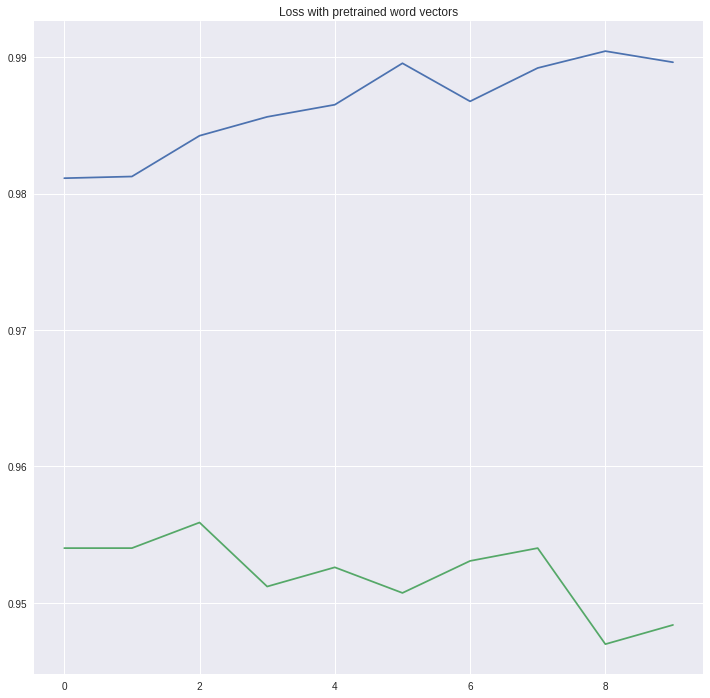

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

history = pd.DataFrame(ar_trained.history)
plt.figure(figsize=(12,12));
# plt.plot(history["loss"]);
# plt.plot(history["val_loss"]);
plt.plot(history["acc"]);
plt.plot(history["val_acc"]);
plt.title("Loss with pretrained word vectors");
plt.show();

In [26]:
X=ar_dpp.process_sentences(["""انت بتقول ايهههه """], lower=True)
X,_ = preprocess_prediction(X,ar_dpp)
arSen.predict(X)
tags[np.argmax(arSen.predict(X))]

100%|██████████| 1/1 [00:00<00:00, 2399.49it/s]


InvalidArgumentError: ignored